In [1]:
import pandas as pd
from pathlib import Path
from drevalpy.datasets.curvecurator import preprocess, _exec_curvecurator, postprocess
import drevalpy
drevalpy.__version__

'1.3.6'

## Load Data

In [2]:
RAW_FILE_PATH = Path("beataml_wv1to4_raw_inhibitor_v4_dbgap.txt")
raw_df = pd.read_csv(RAW_FILE_PATH, sep="\t")
raw_df = raw_df.drop(columns=["dbgap_dnaseq_sample", "dbgap_rnaseq_sample", "run_index", "plate_num", "time_of_read", "passed_qc"])
raw_df = raw_df.drop_duplicates()
raw_df.head()

,dbgap_subject_id,inhibitor,inhibitor_panel,replicate,well_concentration,normalized_viability
0,2262,Cytarabine,Combination,1,10.000,49.732701
1,2262,Cytarabine,Combination,1,3.330,77.707346
2,2262,Cytarabine,Combination,1,1.110,87.032227
3,2262,Cytarabine,Combination,1,0.370,102.573696
4,2262,Cytarabine,Combination,1,0.123,113.452724


In [3]:
raw_df["rounddose"] = raw_df["well_concentration"].round(10)
raw_df["mindose"] = raw_df.groupby(["dbgap_subject_id", "inhibitor"], as_index=False)["rounddose"].transform(min)
raw_df["maxdose"] = raw_df.groupby(["dbgap_subject_id", "inhibitor"], as_index=False)["rounddose"].transform(max)
raw_df["repl"] = raw_df.groupby(["dbgap_subject_id", "inhibitor", "rounddose"], as_index=False)["rounddose"].cumcount()
raw_df.head()

/var/folders/3x/f8j9tddj7flfxt9zx1gkws1m0000gn/T/ipykernel_58533/412585534.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  raw_df["mindose"] = raw_df.groupby(["dbgap_subject_id", "inhibitor"], as_index=False)["rounddose"].transform(min)
/var/folders/3x/f8j9tddj7flfxt9zx1gkws1m0000gn/T/ipykernel_58533/412585534.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  raw_df["maxdose"] = raw_df.groupby(["dbgap_subject_id", "inhibitor"], as_index=False)["rounddose"].transform(max)


,dbgap_subject_id,inhibitor,inhibitor_panel,replicate,well_concentration,normalized_viability,rounddose,mindose,maxdose,repl
0,2262,Cytarabine,Combination,1,10.000,49.732701,10.000,0.0137,10.0,0
1,2262,Cytarabine,Combination,1,3.330,77.707346,3.330,0.0137,10.0,0
2,2262,Cytarabine,Combination,1,1.110,87.032227,1.110,0.0137,10.0,0
3,2262,Cytarabine,Combination,1,0.370,102.573696,0.370,0.0137,10.0,0
4,2262,Cytarabine,Combination,1,0.123,113.452724,0.123,0.0137,10.0,0


In [4]:
drug_dosages = raw_df[["dbgap_subject_id", "inhibitor", "mindose", "maxdose"]].drop_duplicates()
drug_dosages.to_csv("drug_dosages_BeatAML2.csv", index=False)

### Drug name to PubChem mapping

In [5]:
import pubchempy as pcp
results = {}
chembls = {}
manual_review = {}
inchis = {}
i = 0
for drug in raw_df['inhibitor'].unique():
    if i % 10 == 0:
        print(i, '/', len(raw_df['inhibitor'].unique()))
    compounds = pcp.get_compounds(identifier=drug, namespace="name")
    if len(compounds) == 0:
        manual_review[drug] = [compounds]
    else:
        results[drug] = compounds[0].cid
        inchis = compounds[0].inchi
        chembl = None
        for syn in compounds[0].synonyms or []:
            if syn.startswith("CHEMBL"):
                chembl = syn
                break
        chembls[drug] = chembl
    i += 1

0 / 166
10 / 166
20 / 166
30 / 166
40 / 166
50 / 166
60 / 166
70 / 166
80 / 166
90 / 166
100 / 166
110 / 166
120 / 166
130 / 166
140 / 166
150 / 166
160 / 166


In [6]:
print(f'{len(results)} matches, {len(manual_review)} not found')
manual_review |= {brd: cid for brd, cid in results.items() if cid is None}
manual_review

152 matches, 14 not found


{'AZD1152-HQPA (AZD2811)': [[]],
 'Dovitinib (CHIR-258)': [[]],
 'Pazopanib (GW786034)': [[]],
 'Roscovitine (CYC-202)': [[]],
 'Afatinib (BIBW-2992)': [[]],
 'Axitinib (AG-013736)': [[]],
 'Foretinib (XL880)': [[]],
 'Lestaurtinib (CEP-701)': [[]],
 'Masitinib (AB-1010)': [[]],
 'Vargetef': [[]],
 'Vemurafenib (PLX-4032)': [[]],
 'Volasertib (BI-6727)': [[]],
 'AT-101': [[]],
 'Baiclein': [[]]}

In [7]:
manual_review['Pazopanib (GW786034)'] = '10113978' # is Pazopanib
manual_review['Roscovitine (CYC-202)'] = '160355' # is Roscovitine
manual_review['Afatinib (BIBW-2992)'] = '10184653' # is Afatinib
manual_review['Axitinib (AG-013736)'] = '6450551' # is Axitinib
manual_review['Foretinib (XL880)'] = '42642645' # is Foretinib
manual_review['Lestaurtinib (CEP-701)'] = '126565' # is Lestaurtinib
manual_review['Masitinib (AB-1010)'] = '10074640' # is Masitinib
manual_review['Vargetef'] = '135423438' # typo (Vargatef) = Nintedanib
manual_review['Vemurafenib (PLX-4032)'] = '42611257' # is Vemurafenib
manual_review['Volasertib (BI-6727)'] = '10461508' # is Volasertib
manual_review['AT-101'] = '3503' # Gossypol; AT 101 is synonym
manual_review['Baiclein'] = '5281605' # typo, is Baicalein
manual_review['Dovitinib (CHIR-258)'] = '135398510' # was empty
manual_review['AZD1152-HQPA (AZD2811)'] = '16007391' # is Defosbarasertib

In [8]:
def sanitize(val):
    if isinstance(val, int):
        return str(val)
    if isinstance(val, list):
        return ','.join([str(i) for i in val])
    return val
cids = pd.Series(results | manual_review, name="CID").apply(sanitize).astype(str)
cids

Cytarabine                      6253
Entospletinib (GS-9973)     59473233
Nutlin 3a                   11433190
AKT Inhibitor IV             5719375
AKT Inhibitor X             16760284
                             ...    
Vargetef                   135423438
Vemurafenib (PLX-4032)      42611257
Volasertib (BI-6727)        10461508
AT-101                          3503
Baiclein                     5281605
Name: CID, Length: 166, dtype: object

In [9]:
chembls = pd.Series(chembls, name="CHEMBL")
raw_df = raw_df.drop(columns=['inhibitor_panel', 'replicate', 'well_concentration'])
full_df = raw_df.merge(cids, left_on='inhibitor', right_index=True).merge(chembls, left_on='inhibitor', right_index=True, how='left')
# The required columns are "dose", "response", "sample", and "drug", with an optional "replicate" column.
full_df.rename(columns={'dbgap_subject_id': 'sample', 'inhibitor': 'drug_name', 'rounddose': 'dose', 'CID': 'drug', 'normalized_viability': 'response', 'repl': 'replicate'}, inplace=True)
full_df.to_csv('viabilities_processed.csv', index=None)
full_df

,sample,drug_name,response,dose,mindose,maxdose,replicate,drug,CHEMBL
0,2262,Cytarabine,49.732701,10.0000,0.0137,10.0,0,6253,CHEMBL803
1,2262,Cytarabine,77.707346,3.3300,0.0137,10.0,0,6253,CHEMBL803
2,2262,Cytarabine,87.032227,1.1100,0.0137,10.0,0,6253,CHEMBL803
3,2262,Cytarabine,102.573696,0.3700,0.0137,10.0,0,6253,CHEMBL803
4,2262,Cytarabine,113.452724,0.1230,0.0137,10.0,0,6253,CHEMBL803
...,...,...,...,...,...,...,...,...,...
555578,2800,Venetoclax,42.720800,1.1100,0.0137,10.0,6,49846579,CHEMBL3137309
555579,2800,Venetoclax,43.610817,0.3700,0.0137,10.0,6,49846579,CHEMBL3137309
555580,2800,Venetoclax,44.500833,0.1230,0.0137,10.0,6,49846579,CHEMBL3137309
555581,2800,Venetoclax,43.610817,0.0412,0.0137,10.0,6,49846579,CHEMBL3137309


In [10]:
# check for duplicates
print(len(full_df))
print(len(full_df[["sample", "drug", "dose", "response", "replicate"]].drop_duplicates()))
full_df[full_df[["sample", "drug", "dose", "response", "replicate"]].duplicated()]

555423
555423


,sample,drug_name,response,dose,mindose,maxdose,replicate,drug,CHEMBL


## DrEvalPy: run CurveCurator

In [18]:
preprocess(input_file='viabilities_processed.csv', output_dir='curvecurator', dataset_name='BeatAML2', cores=6, normalize=True)

In [19]:
_exec_curvecurator(Path('curvecurator'))

In [20]:
postprocess('curvecurator', dataset_name='BeatAML2')

## Postprocess for Zenodo

* Quality control
* Set EC50s outside the measured range to NaN
* Set IC50s outside 10*max/10**-1 min measured range to NaN


In [56]:
viability_df = pd.read_csv('curvecurator/BeatAML2.csv', converters={'cell_line_name': str, 'pubchem_id': str})
full_df = pd.read_csv('viabilities_processed.csv', converters={'sample': str, 'drug': str})[['sample', 'drug', 'drug_name', 'CHEMBL', 'mindose', 'maxdose', ]].drop_duplicates()
viability_df = viability_df.merge(full_df, left_on=['cell_line_name', 'pubchem_id'], right_on=['sample', 'drug'])

In [57]:
# join with original data
original_measures_df = pd.read_csv('beataml_probit_curve_fits_v4_dbgap.txt', sep='\t', converters={'dbgap_subject_id': str, 'inhibitor': str})
viability_df = viability_df.merge(original_measures_df, left_on=['cell_line_name', 'drug_name'], right_on=['dbgap_subject_id', 'inhibitor'])

<Axes: xlabel='AUC_curvecurator', ylabel='auc'>

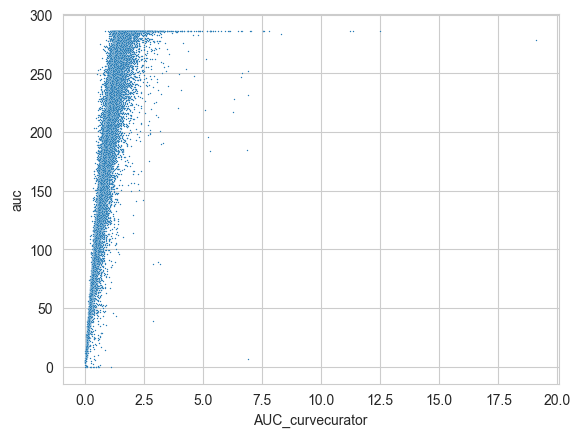

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(viability_df, x="AUC_curvecurator", y="auc", s=1)

(0.0, 1.0)

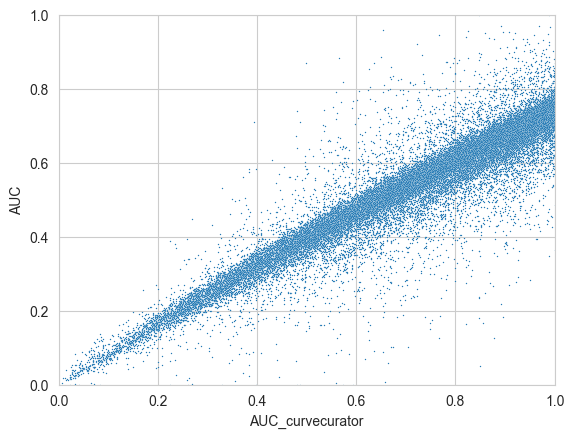

In [59]:
# min-max scaling
viability_df['AUC'] = (viability_df['auc'] - viability_df['auc'].min()) / (viability_df['auc'].max() - viability_df['auc'].min())
sns.scatterplot(viability_df, x="AUC_curvecurator", y="AUC", s=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

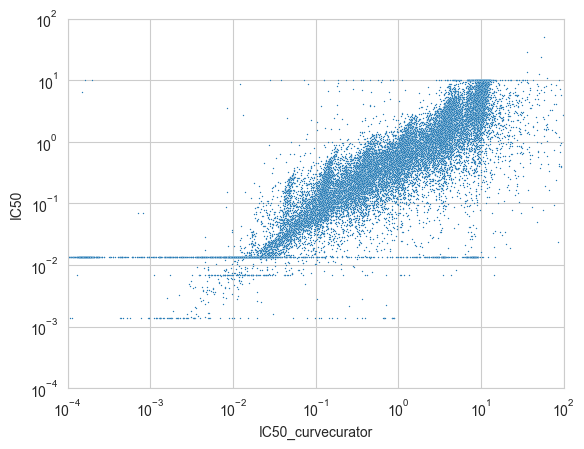

In [60]:
viability_df = viability_df.rename(columns={"ic50": "IC50"})
sns.scatterplot(viability_df, x="IC50_curvecurator", y="IC50", s=1)
plt.xlim(1e-4, 1e2)
plt.ylim(1e-4, 1e2)
plt.xscale('log')
plt.yscale('log')

In [61]:
viability_df["min_dose_M"] = 10**-6 * viability_df["mindose"]
viability_df["max_dose_M"] = 10**-6 * viability_df["maxdose"]

In [62]:
import numpy as np
def plot_curve(df, index):
    # plot is in M -> change units that need to be changes
    front = df.loc[index, "Front"] # unitless
    back = df.loc[index, "Back"] # unitless
    ec50 = df.loc[index, "EC50_curvecurator"] * 10**-6 # transform from µM to M

    slope = df.loc[index, "Slope"] # unitless
    ic50 = df.loc[index, "IC50_curvecurator"] * 10**-6 # transform from µM to M
    origAUC = df.loc[index, "AUC"] # unitless
    origic50 = df.loc[index, "IC50"] * 10**-6

    min_dosis = df.loc[index, "min_dose_M"]
    max_dosis = df.loc[index, "max_dose_M"]

    # curve fit: (front-back)/(1+(x/EC50)^slope) + back = (front-back) / (1+10^(slope*(log10(x)-log10(EC50)) + back; -log10(EC50) = pEC50
    xvals = 10**np.linspace(np.log10(min_dosis)-2, np.log10(max_dosis)+2, 1000)
    xvals_logged = np.log10(xvals)
    y = (front - back) / (1 + 10 ** (slope * (xvals_logged -np.log10(ec50)))) + back
    plt.scatter(xvals, y, s=1)

    plt.axvline(origic50, linestyle='--')
    plt.text(x=origic50, y=0.8, s='IC50 orig', color='blue')
    plt.axvline(ic50, color="red")
    plt.text(x=ic50, y=1.0, s='IC50 curvecurator', color='red')
    plt.axvline(ec50, color="orange")
    plt.text(x=ec50, y=0.6, s='EC50 curvecurator', color='orange')
    plt.axvline(x=min_dosis, color="green")
    plt.text(x=min_dosis, y=0.4, s='min dose [M]', color='green')
    plt.axvline(x=max_dosis, color="green")
    plt.text(x=max_dosis, y=0.4, s='max dose [M]', color='green')

    auc = df.loc[index, "AUC_curvecurator"]
    plt.title(f"AUC: {auc}, Original AUC: {origAUC}")

    plt.axhline(0.5, linestyle='--', color='black')
    plt.xscale('log')
    plt.xlim(min_dosis*10**-2, max_dosis*10**2)
    plt.ylim(0, 2)

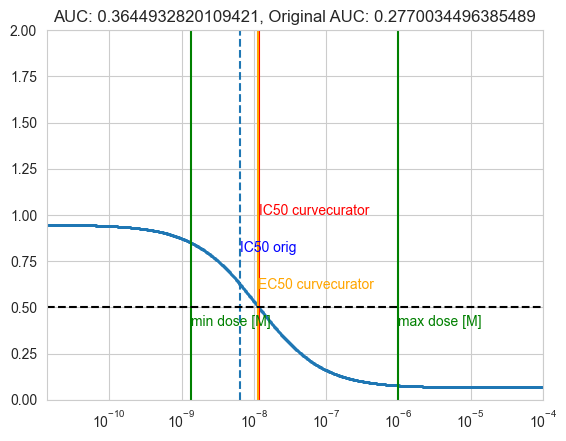

In [70]:
plot_curve(viability_df, 8)

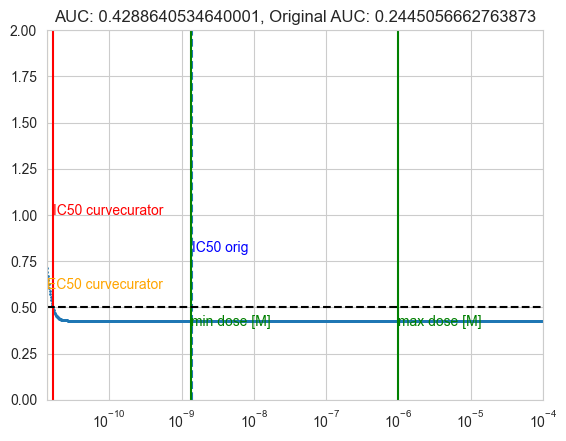

In [71]:
# curvecurator caps EC50s at 10**2 max dose/10**-2 min dose but we want to set them to NaN if they are outside the measured range
plot_curve(viability_df,17881)

In [73]:
# pEC50 = -log10(dosis[µM]); allow 10^-1 to 10^2 times the min/max dose for IC50
drug_dosages = pd.read_csv("drug_dosages_BeatAML2.csv")
min_doses_pEC50 = {f'{row["dbgap_subject_id"]}|{row["inhibitor"]}': -np.log10(row["mindose"]) for index, row in drug_dosages.iterrows()}
max_doses_pEC50 = {f'{row["dbgap_subject_id"]}|{row["inhibitor"]}': -np.log10(row["maxdose"]) for index, row in drug_dosages.iterrows()}
min_doses_IC50 = {f'{row["dbgap_subject_id"]}|{row["inhibitor"]}': 10**-1 * row["mindose"] for index, row in drug_dosages.iterrows()}
max_doses_IC50 = {f'{row["dbgap_subject_id"]}|{row["inhibitor"]}': 10**2 * row["maxdose"] for index, row in drug_dosages.iterrows()}

num_pEC50s_nan = viability_df["pEC50_curvecurator"].isna().sum()
num_ic50s_nan = viability_df["IC50_curvecurator"].isna().sum()

new_pEC50s = viability_df.apply(lambda x: x["pEC50_curvecurator"] if min_doses_pEC50[f"{x['cell_line_name']}|{x['drug_name']}"] >= x["pEC50_curvecurator"] >= max_doses_pEC50[f"{x['cell_line_name']}|{x['drug_name']}"] else np.nan, axis=1)

new_IC50s = viability_df.apply(lambda x: x["IC50_curvecurator"] if min_doses_IC50[f"{x['cell_line_name']}|{x['drug_name']}"] <= x["IC50_curvecurator"] <= max_doses_IC50[f"{x['cell_line_name']}|{x['drug_name']}"] else np.nan, axis=1)

In [74]:
viability_df["pEC50_curvecurator"] = new_pEC50s
viability_df["IC50_curvecurator"] = new_IC50s
print(f"From {num_pEC50s_nan} to {viability_df['pEC50_curvecurator'].isna().sum()} NaN pEC50s / {len(viability_df)}")
print(f"From {num_ic50s_nan} to {viability_df['IC50_curvecurator'].isna().sum()} NaN IC50s / {len(viability_df)}")

From 0 to 16101 NaN pEC50s / 62487
From 39944 to 40646 NaN IC50s / 62487


In [75]:
viability_df.to_csv("BeatAML2.csv", index=False)